In [43]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, log_loss, make_scorer
import numpy as np
import pandas as pd
import multiprocessing
import concurrent.futures
import uproot
import collections
import matplotlib.pyplot as plt

In [44]:
Tree = uproot.open("/data/atlas/atlasdata3/ambroz/VHbb/FSRandSoftMETnTausntuples.root")["Nominal"]

In [45]:
Tree.show()

sample                     TStreamerInfo              asgenobj(STLString())
EventWeight                (no streamer)              asdtype('>f4')
bTagWeight                 (no streamer)              asdtype('>f4')
EventNumber                (no streamer)              asdtype('>u8')
ChannelNumber              (no streamer)              asdtype('>i4')
nJ                         (no streamer)              asdtype('>i4')
nSigJet                    (no streamer)              asdtype('>i4')
nForwardJet                (no streamer)              asdtype('>i4')
nTags                      (no streamer)              asdtype('>i4')
nTaus                      (no streamer)              asdtype('>i4')
MET                        (no streamer)              asdtype('>f4')
MEff                       (no streamer)              asdtype('>f4')
METSig                     (no streamer)              asdtype('>f4')
dPhiVBB                    (no streamer)              asdtype('>f4')
dEtaVBB                    

In [46]:
DataFrame = Tree.pandas.df(["nJ", 
                            "MET", "MEff", "dPhiVBB", "pTB1", "pTB2", "mBB", "dRBB", "dEtaBB", "pTJ3", "mBBJ",
                            "nTaus", "hasFSR", "softMET",
                            "dRBBJ",
                            "bin_MV2c10B1","bin_MV2c10B2","bin_MV2c10J3",
                            "EventWeight", "nTags", "sample"])

In [47]:
DataFrame = DataFrame[ (DataFrame["sample"] != b'data')
                   &   (DataFrame["sample"] != b'qqZvvH125cc') 
                   &   (DataFrame["sample"] != b'qqWlvH125cc')
                   &   (DataFrame["sample"] != b'qqZllH125cc')
                   &   (DataFrame["sample"] != b'ggZvvH125cc')
                   &   (DataFrame["sample"] != b'ggZllH125cc')
                   &   (DataFrame["nTags"]  == 2)
                   &   (DataFrame["nJ"] < 4) ]

In [48]:
DataFrame = DataFrame.drop("nTags",axis=1)

In [49]:
DataFrame['bin_MV2c10B1plusbin_MV2c10B2'] = DataFrame['bin_MV2c10B1'] + DataFrame['bin_MV2c10B2']

In [50]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def weightedCorrMatrix(sample, nJ, varList, DataFrame):
    """Weighted Correlation Matrix"""
    
    DataFramenJ = DataFrame[DataFrame["nJ"] == nJ]
    DataFrameSample = DataFramenJ[DataFramenJ["sample"] == sample]
    
    x = 0
    y = 0
    
    n_vars = len(varList)
    matrix = np.zeros((n_vars, n_vars))
    
    for varY in varList:
        for varX in varList:
            
            if y > x:
                x+=1
                continue
            
            val = corr(DataFrameSample[varX], DataFrameSample[varY], DataFrameSample['EventWeight'])
                
            matrix[x][y] = val
            matrix[y][x] = val
            
            x+=1
            
        x=0
        y+=1
         
    
    fig, ax = plt.subplots(figsize=(19, 18))
    im = ax.imshow(matrix, cmap='coolwarm', vmin = -1, vmax = 1)
    
    ax.set_xticks(np.arange(n_vars))
    ax.set_yticks(np.arange(n_vars))
    ax.set_xticklabels(varList)
    ax.set_yticklabels(varList)
    
    for i in range(n_vars):
        for j in range(n_vars):
            text = ax.text(j, i, round(matrix[i, j], 2), ha="center", va="center", color="black")
    
    title = 'Correlation Matrix for 0-Lepton ' + str(sample) + ' 2tag' + str(nJ) + 'jet'
    title = title.replace("b'",'',1)
    title = title.replace("'",'')
    plt.title(title, fontsize = 20)
    
    plt.savefig('corr_' + str(sample)  + '_' + str(nJ) + 'njet' + '.pdf')
    
    plt.show()

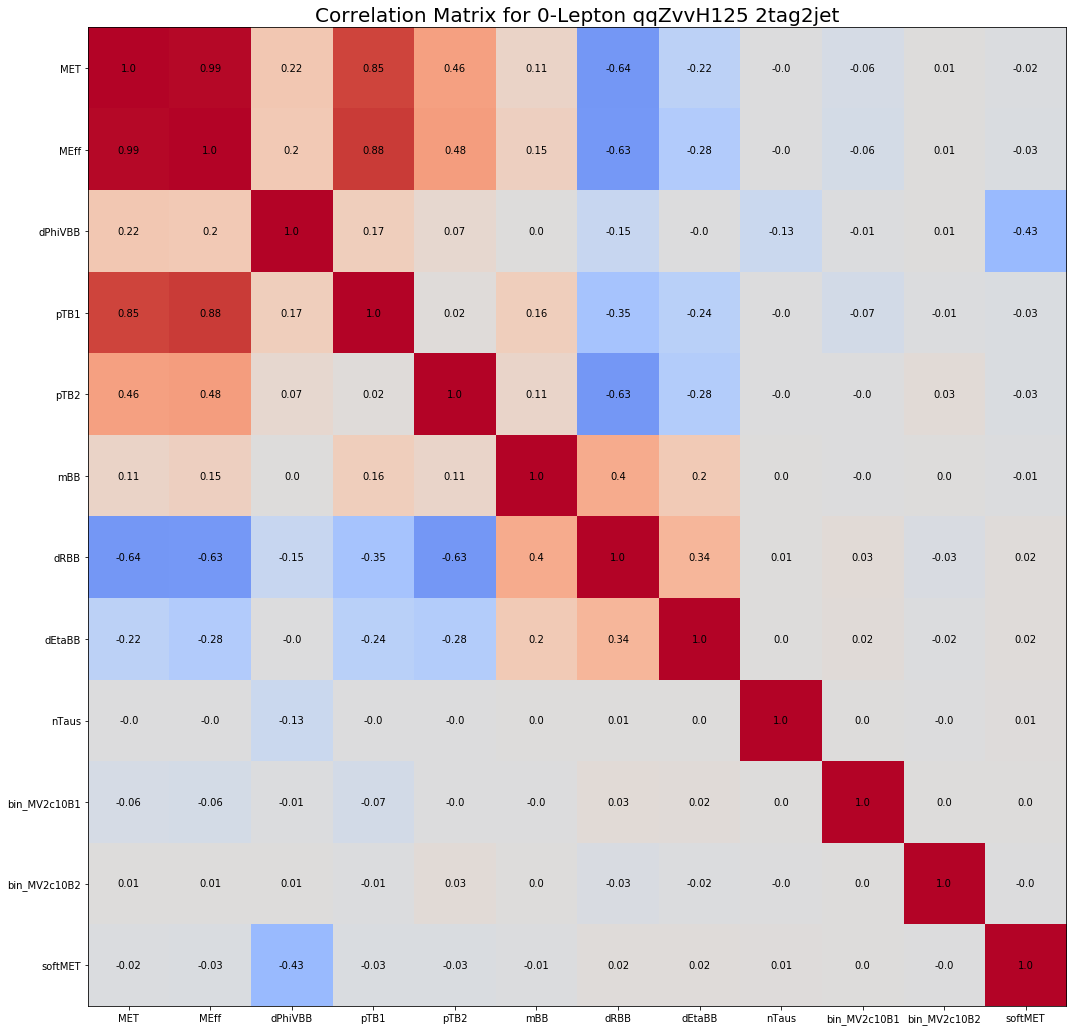

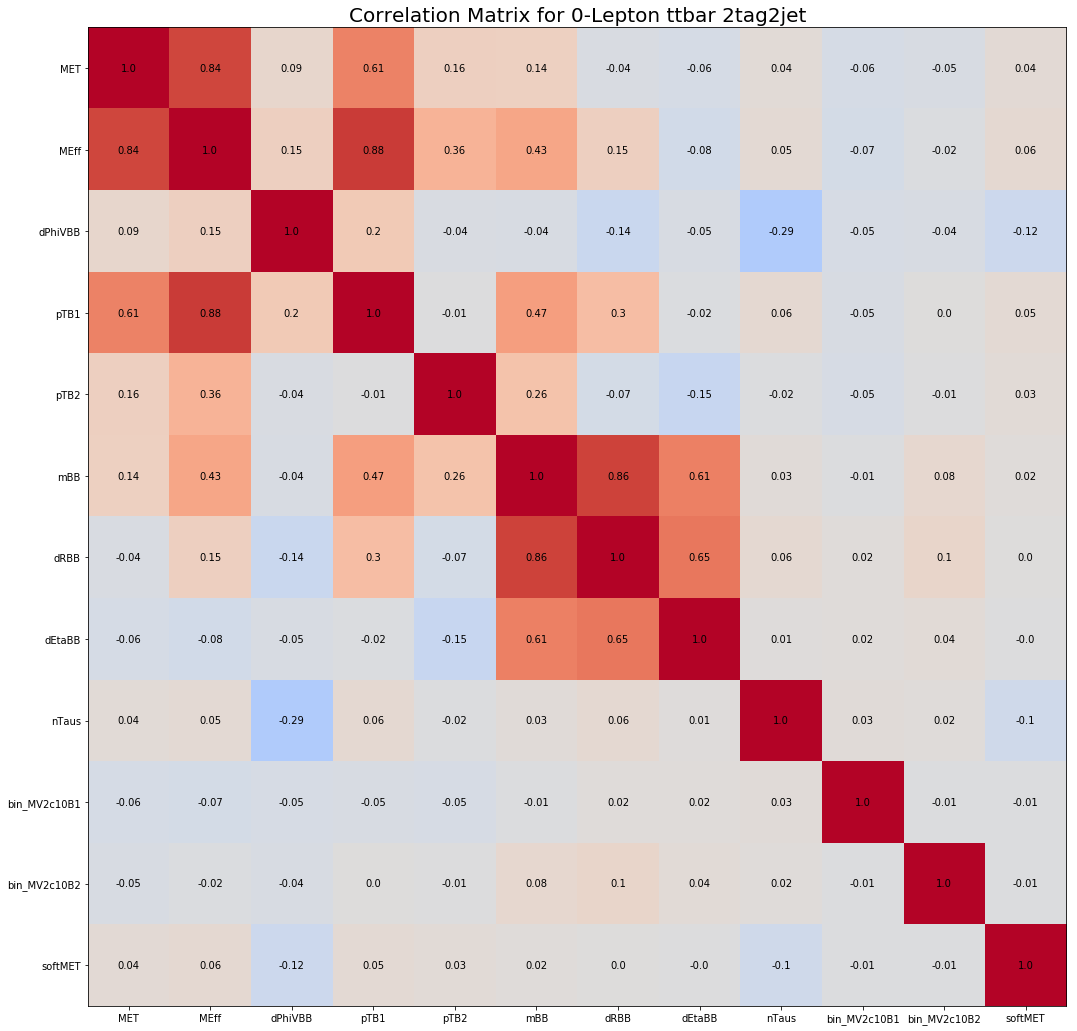

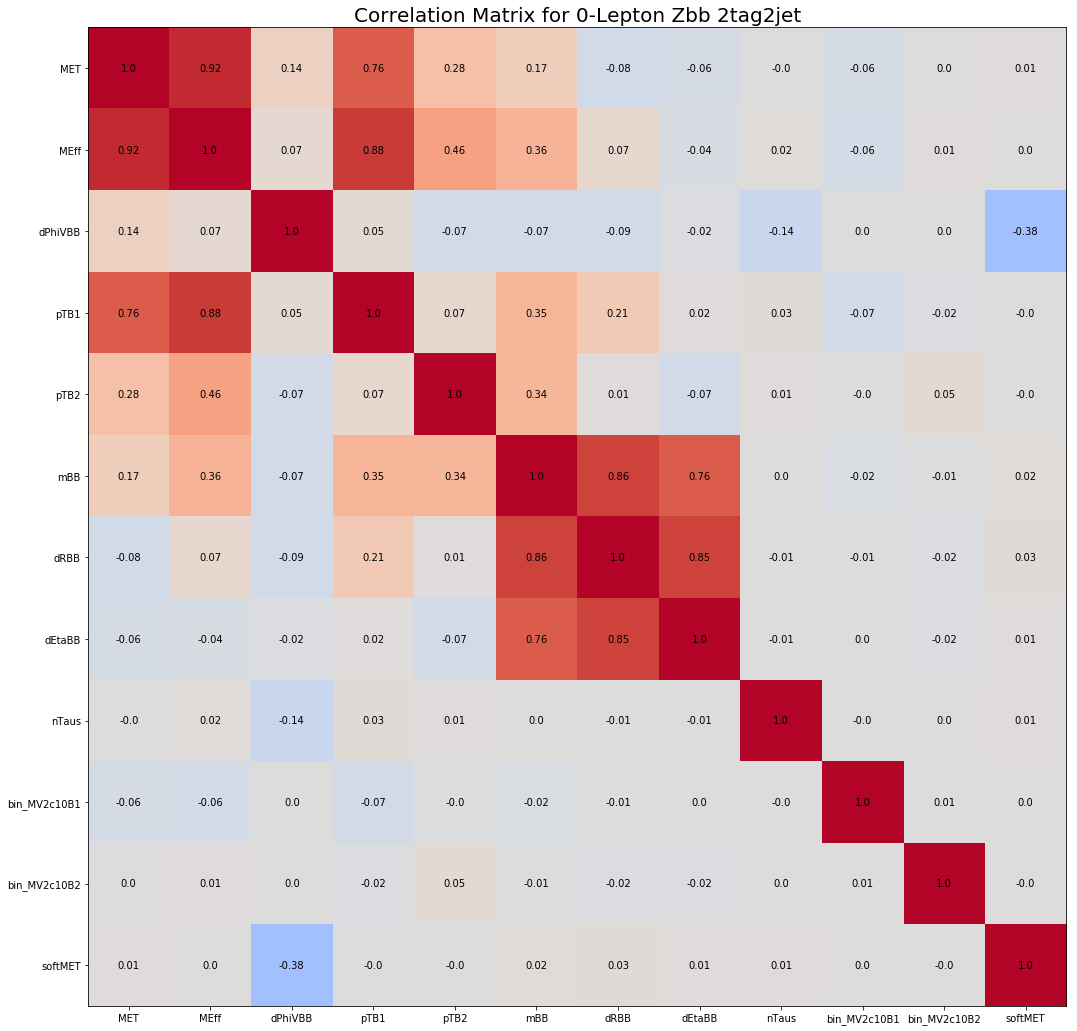

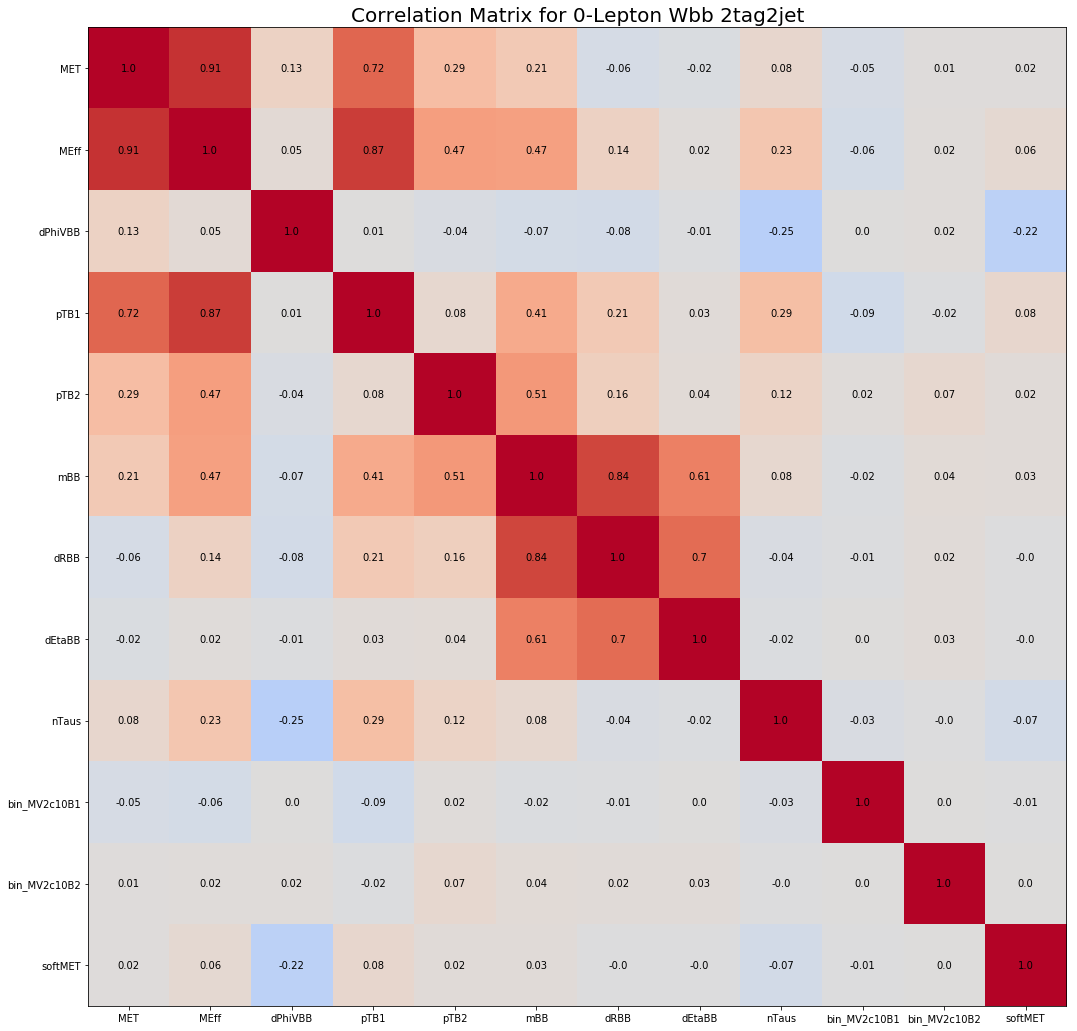

In [51]:
samples = [b'qqZvvH125', b'ttbar', b'Zbb', b'Wbb']
for sample in samples:
    weightedCorrMatrix(sample, 2, 
                       ["MET", "MEff", "dPhiVBB", "pTB1", "pTB2", "mBB", "dRBB", "dEtaBB",
                        "nTaus", #"hasFSR",
                        "bin_MV2c10B1","bin_MV2c10B2",
                        "softMET"
                       ], DataFrame)

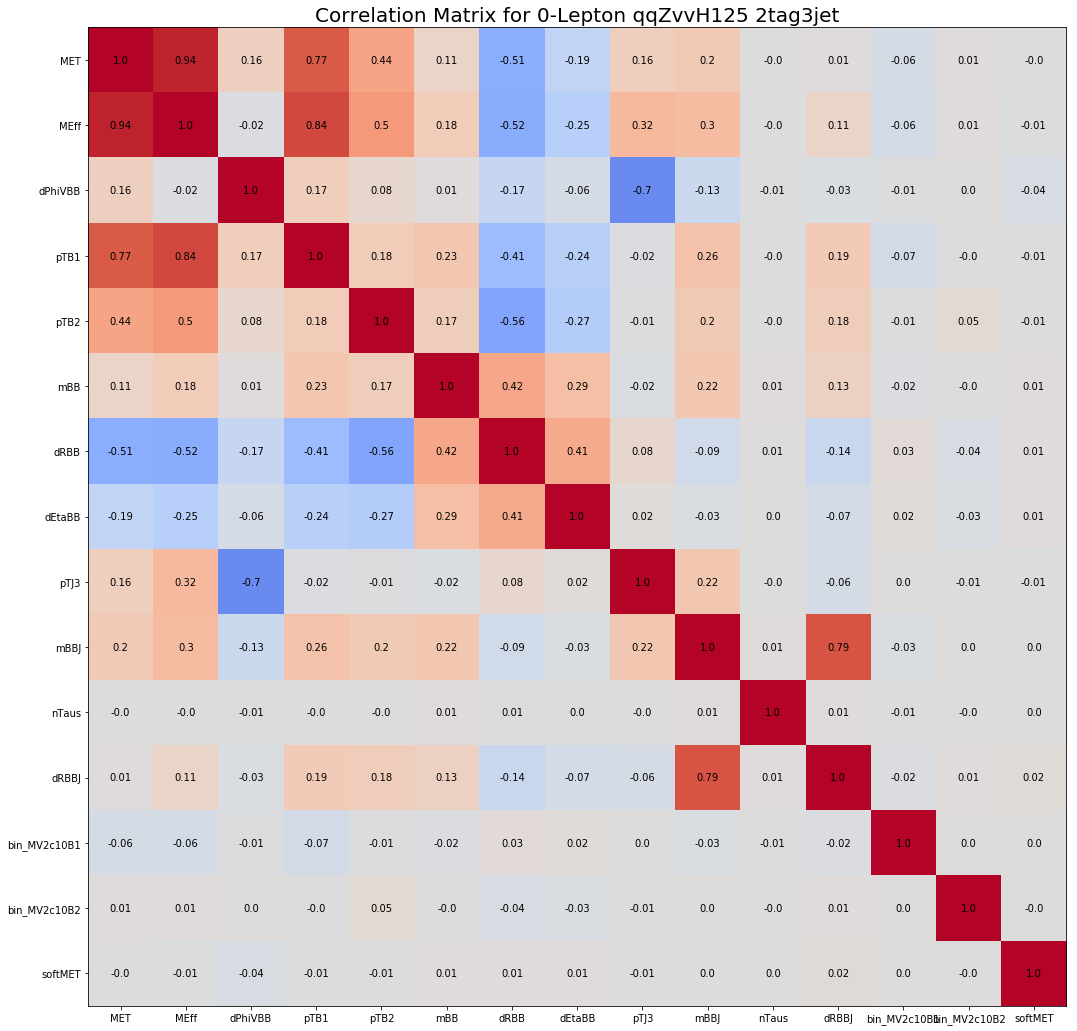

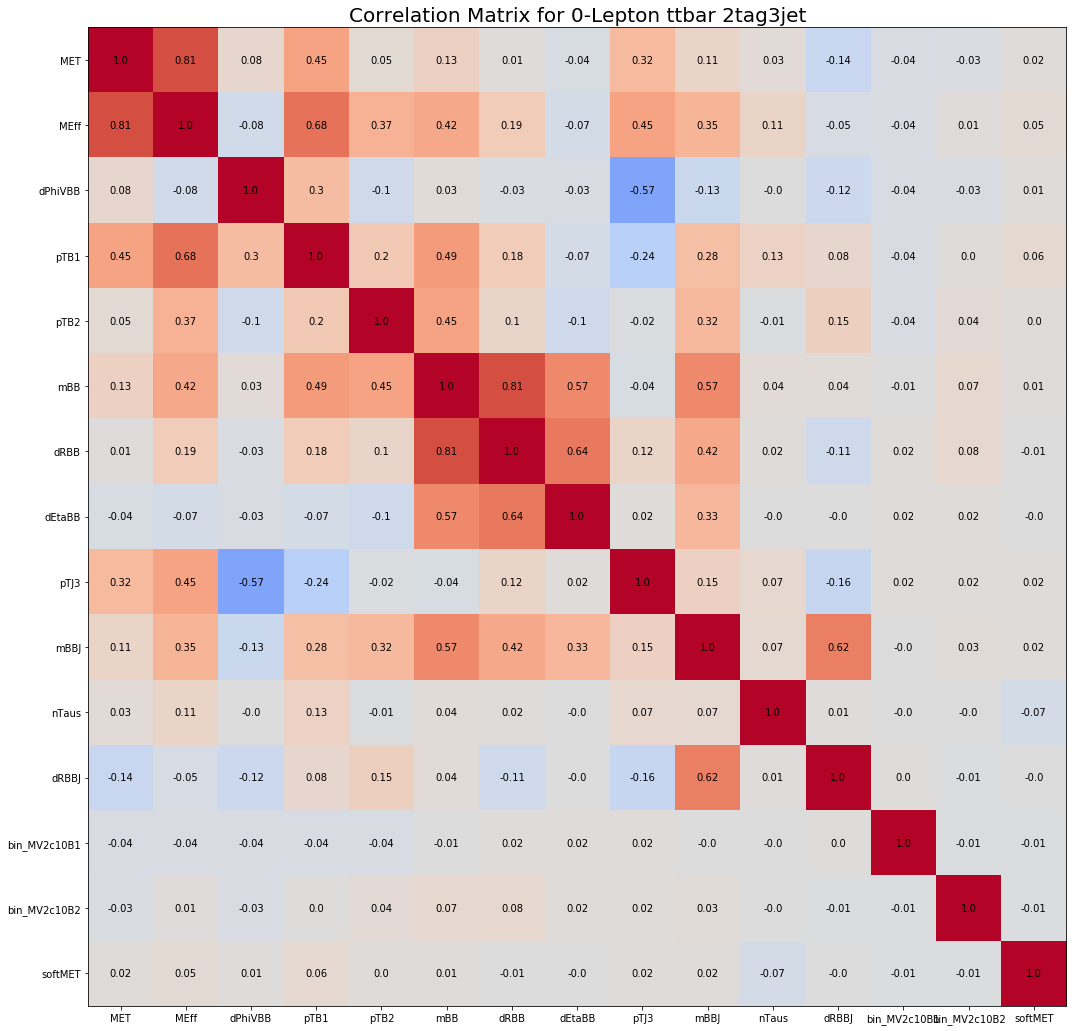

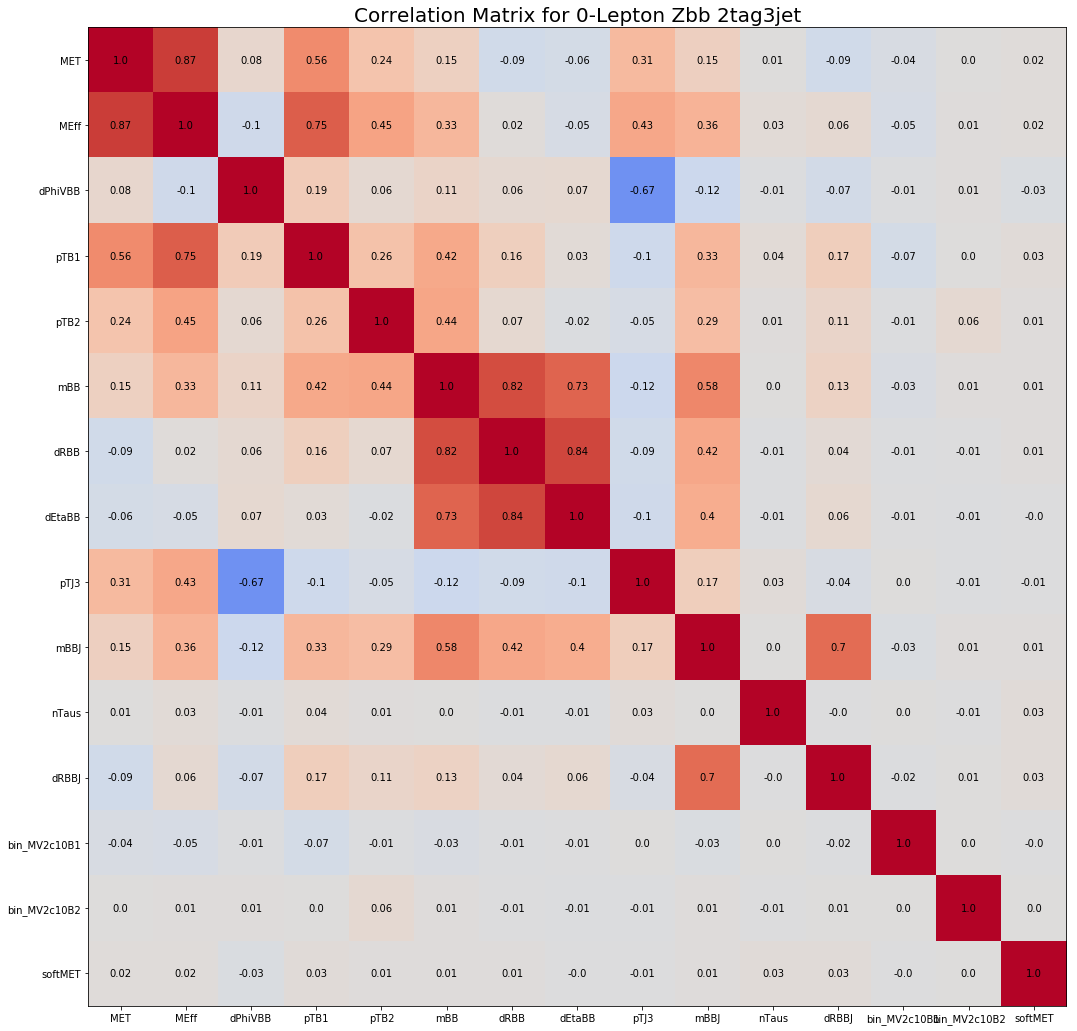

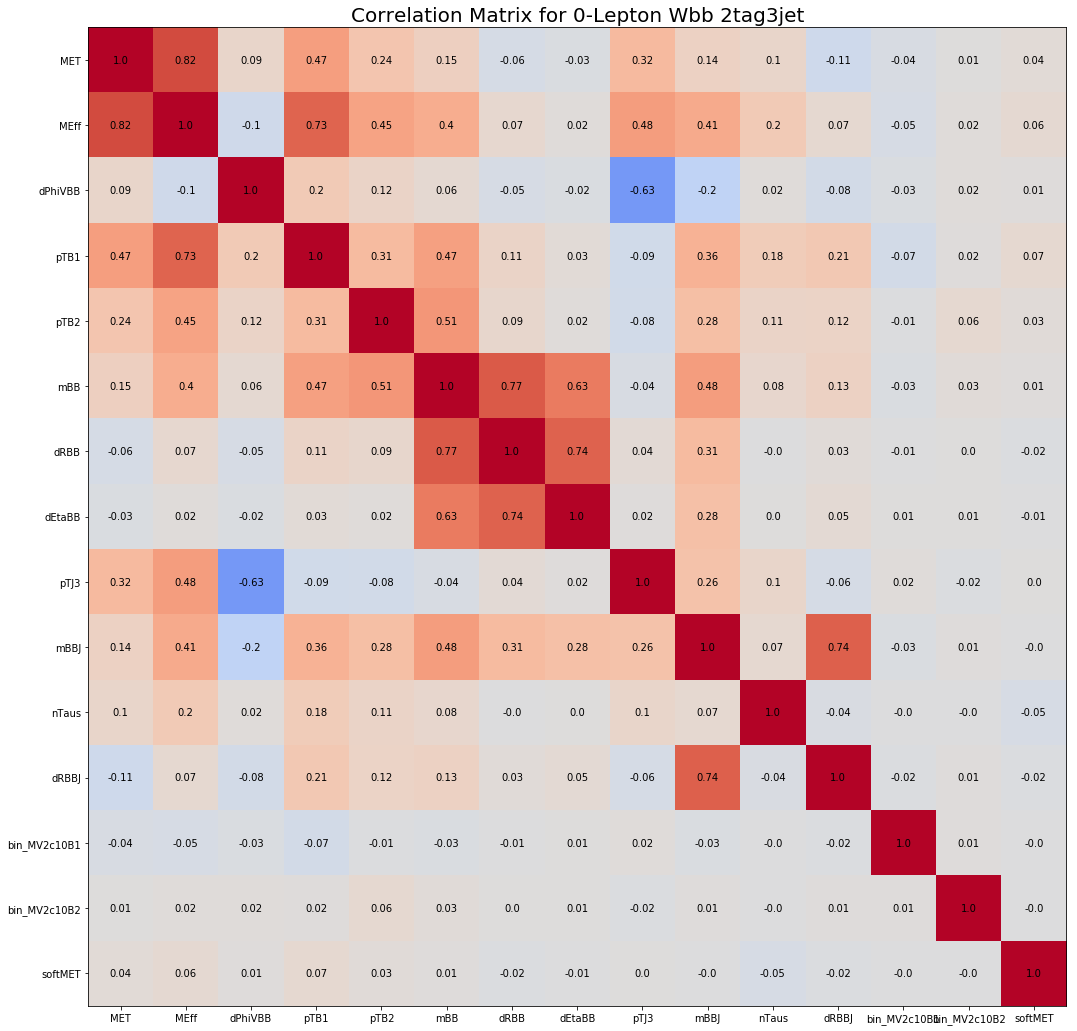

In [63]:
samples = [b'qqZvvH125', b'ttbar', b'Zbb', b'Wbb']
for sample in samples:
    weightedCorrMatrix(sample, 3, 
                       ["MET", "MEff", "dPhiVBB", "pTB1", "pTB2", "mBB", "dRBB", "dEtaBB", "pTJ3", "mBBJ",
                        "nTaus", "dRBBJ",
                        "bin_MV2c10B1","bin_MV2c10B2",
                        "softMET"], DataFrame)

In [53]:
def plotShape(samples, nJ, var, n_bins, x_min, x_max, DataFrame, unit = ''):
    """Plot shapes in samples"""
    
    colors = {b'qqZvvH125' : 'C3', b'ttbar' : 'C1', b'Wbb' : 'C2', b'Zbb' : 'C0', b'ZZ'  : 'C7'}
    
    DataFramenJ = DataFrame[DataFrame["nJ"] == nJ]
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    for sample in samples:
        
        samplename = str(sample)
        samplename = samplename.replace("b'",'',1)
        samplename = samplename.replace("'",'')
        
        DataFrameSample = DataFramenJ[DataFramenJ["sample"] == sample]
        DataFrameSample[var].plot.hist(ax=ax, 
                                       histtype=u'step', 
                                       color = colors[sample],
                                       label = samplename,
                                       linewidth=2,
                                       legend=True, 
                                       bins=n_bins, 
                                       range=(x_min, x_max),
                                       weights = DataFrameSample['EventWeight'],
                                       density = True
                                        )
        
        
    
    if len(unit) > 0:
        ax.set_xlabel(var + ' [' + unit + ']', x=0.9, y=0.6, fontsize = 14)
    else:
        ax.set_xlabel(var, x=0.9, y=0.6, fontsize = 14)
    ax.set_ylabel('a.u.', fontsize = 14)
    
    plt.title('0-Lepton 2tag' + str(nJ) + 'jet', fontsize = 20)
    
    plt.savefig('shapes_' + var + '_' + str(nJ) + 'njet' + '.pdf')
    plt.show()

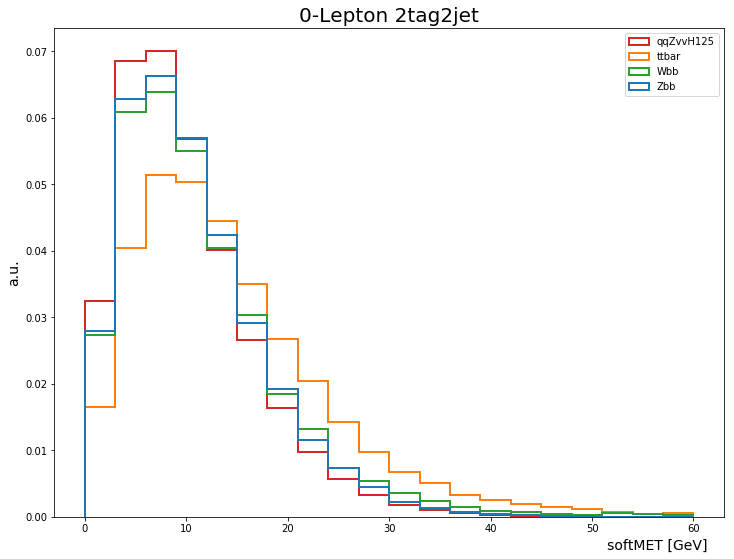

In [54]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'softMET', 20, 0, 60, DataFrame, 'GeV')
#plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'softMET', 20, 0, 60, DataFrame[DataFrame['MET'] < 170], 'GeV')

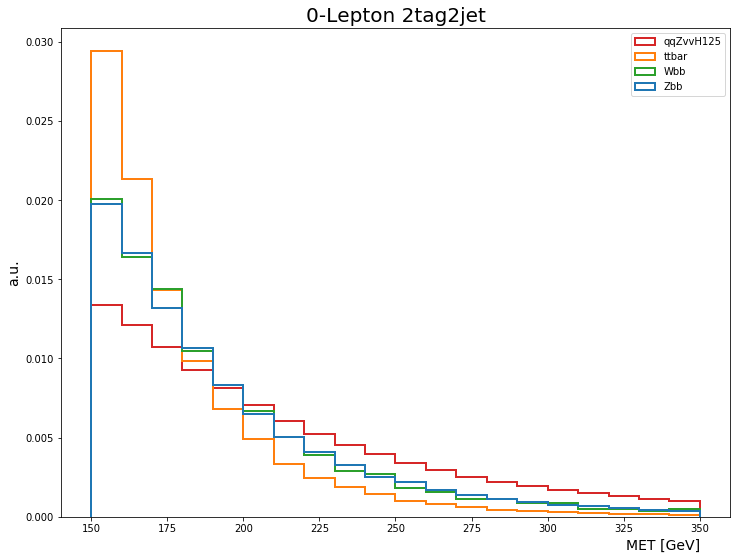

In [55]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'MET', 20, 150, 350, DataFrame, 'GeV')
#plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'MET', 20, 150, 350, DataFrame[DataFrame['MET'] < 170], 'GeV')

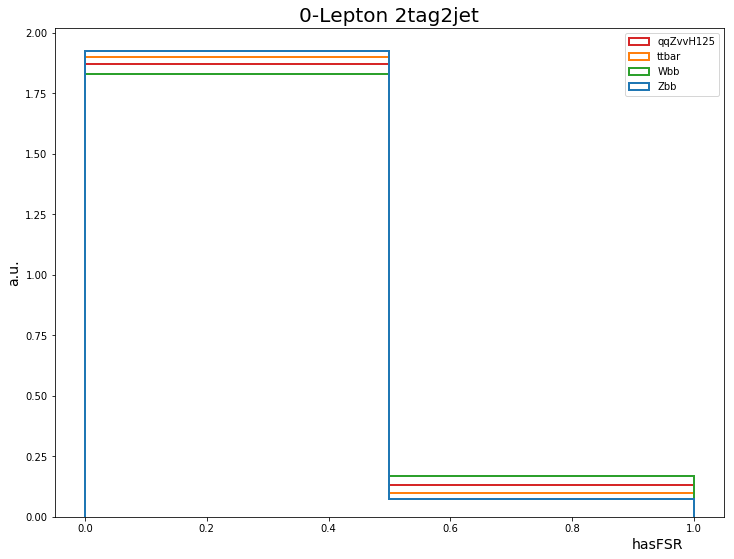

In [56]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'hasFSR', 2, 0, 1, DataFrame)

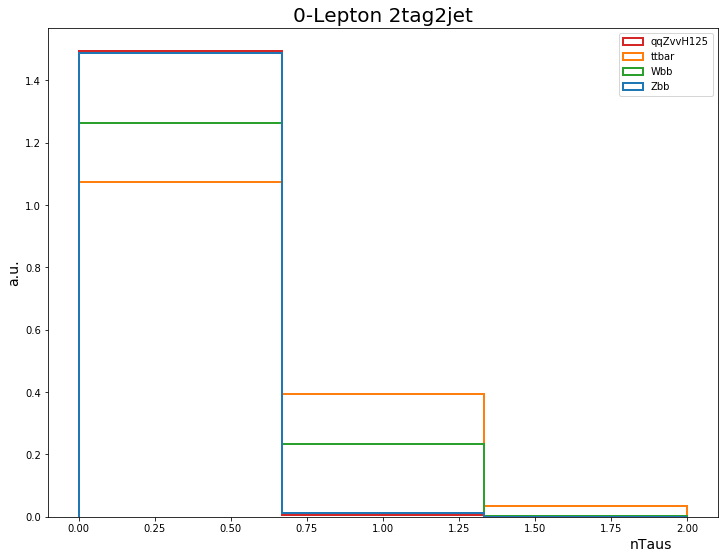

In [57]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'nTaus', 3, 0, 2, DataFrame)

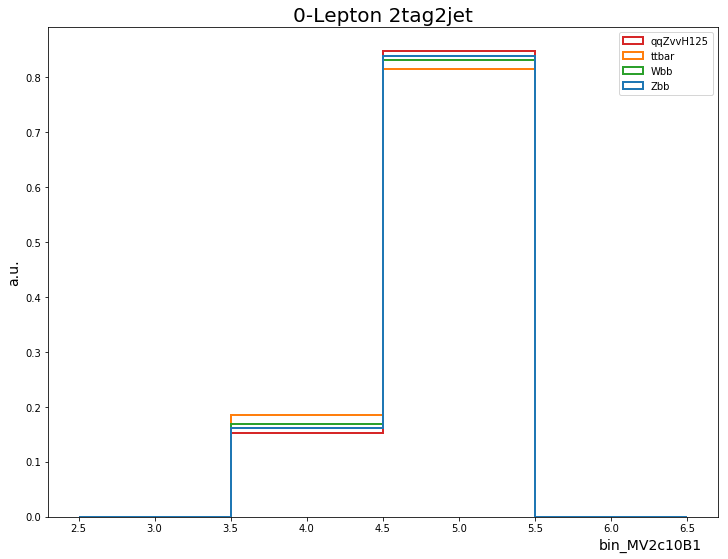

In [58]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'bin_MV2c10B1', 4, 2.5, 6.5, DataFrame)

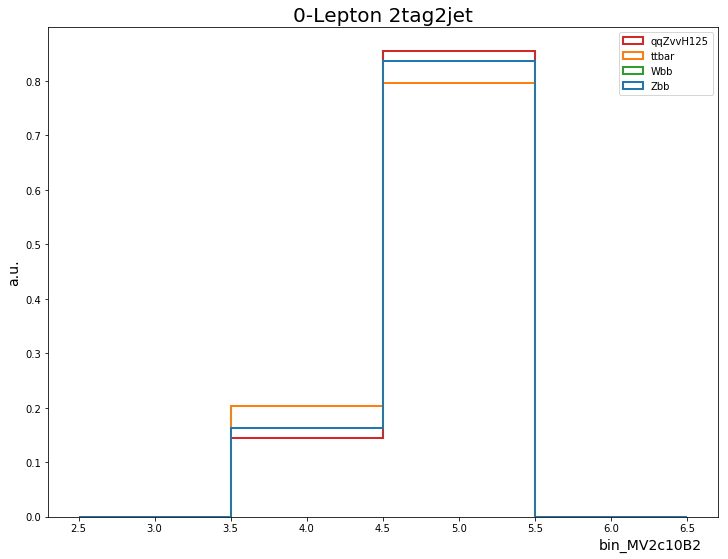

In [59]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 2, 'bin_MV2c10B2', 4, 2.5, 6.5, DataFrame)

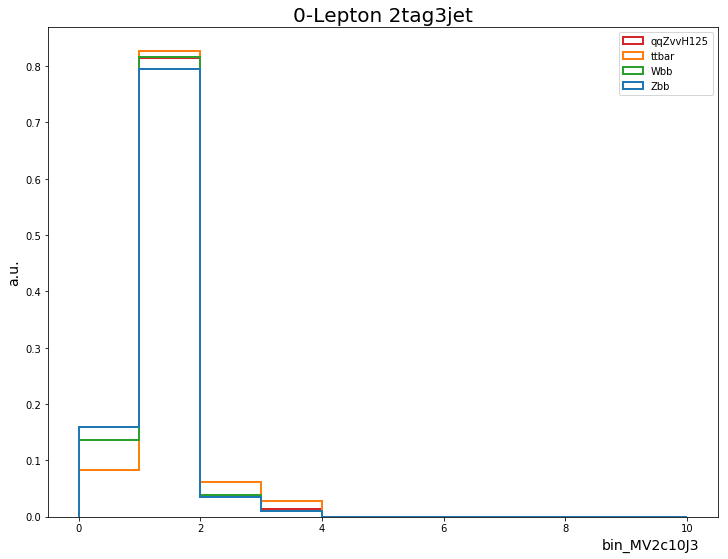

In [60]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 3, 'bin_MV2c10J3', 10, 0, 10, DataFrame)

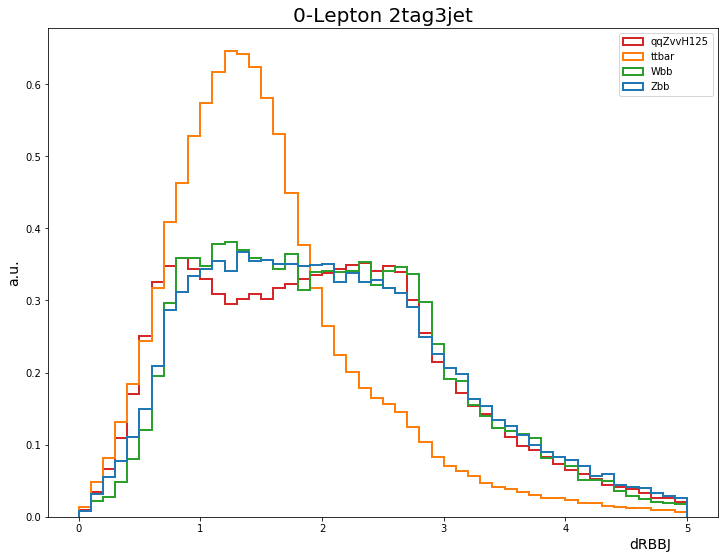

In [61]:
plotShape([b'qqZvvH125', b'ttbar', b'Wbb', b'Zbb'], 3, 'dRBBJ', 50, 0, 5, DataFrame)

In [64]:
def myRange(start,end,step):
    i = start
    while i < end:
        yield i
        i += step
    yield end

def plot2Dsquare(samples, nJ, varX, varY, DataFrame, unitX = '', unitY = ''):
    """Plot square"""
    
    colors = {b'qqZvvH125' : 'C3', b'ttbar' : 'C1', b'Wbb' : 'C2', b'Zbb' : 'C0', b'ZZ'  : 'C7'}
    offset = {b'qqZvvH125' : 0, b'ttbar' : 3, b'Wbb' : 6, b'Zbb' : 8, b'ZZ'  : 10}
    
    DataFramenJ = DataFrame[DataFrame["nJ"] == nJ]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    for sample in samples:
        
        samplename = str(sample)
        samplename = samplename.replace("b'",'',1)
        samplename = samplename.replace("'",'')
        
        DataFrameSample = DataFramenJ[DataFramenJ["sample"] == sample]
        
        TotEventWeight = DataFrameSample['EventWeight'].sum()
        matrix, _, _, _ = plt.hist2d(DataFrameSample[varX], DataFrameSample[varY], 
                                     bins=(20,20), range=((150,350),(0,40)),
                                     weights = DataFrameSample['EventWeight'] / TotEventWeight,
                                     visible= False) 
        
        
        x_coord = []
        y_coord = []
        x = 0
        y = 0
        for y in range(0,40, 2):
            for x in range(150,350, 10):
                x_coord.append(x+offset[sample])
                y_coord.append(y)
        
        size = []
        for x in myRange(0, 19, 1):
            for y in myRange(0, 19, 1):
                size.append(matrix[y,x] * 10000)

                
        ax.scatter(
            x=x_coord, # Use mapping for x
            y=y_coord, # Use mapping for y
            s = size,
            label = samplename,
            color = colors[sample],
            marker='s' # Use square as scatterplot marker
        )
        
    
    if len(unitX) > 0:
        varX = varX + ' [' + unitX + ']'
    ax.set_xlabel(varX, x=0.9, y=0.6, fontsize = 14)
    
    if len(unitY) > 0:
        varY = varY + ' [' + unitY + ']'
    ax.set_ylabel(varY, x=0.1, y=0.9, fontsize = 14)
    
    plt.legend(loc='upper right')
    plt.title('0-Lepton 2tag' + str(nJ) + 'jet', fontsize = 20)
    
    plt.savefig('square_' +  varX + '_' + varY + '_' + str(nJ) + 'njet' + '.pdf')
    
    plt.show()

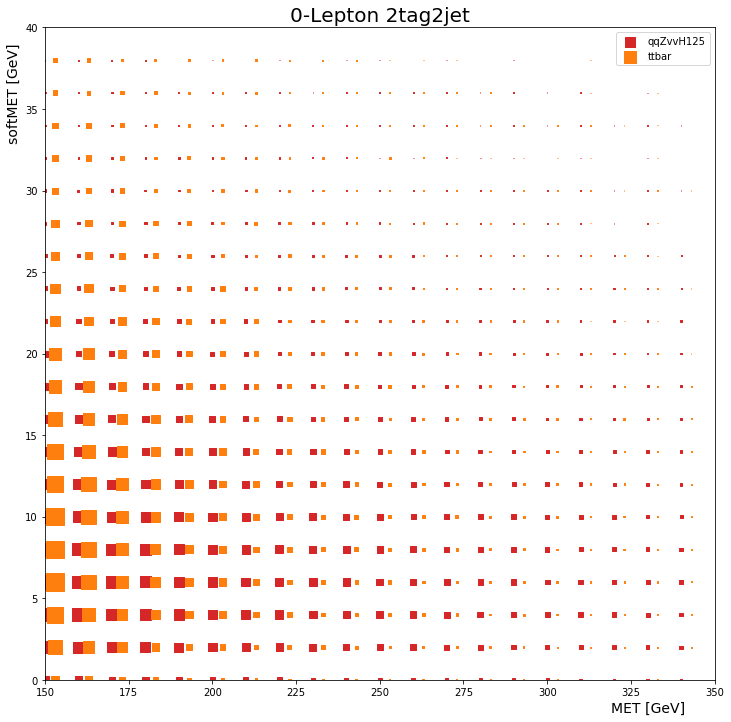

In [65]:
plot2Dsquare([b'qqZvvH125',b'ttbar'], 2, "MET", "softMET", DataFrame, unitX = 'GeV', unitY = 'GeV')

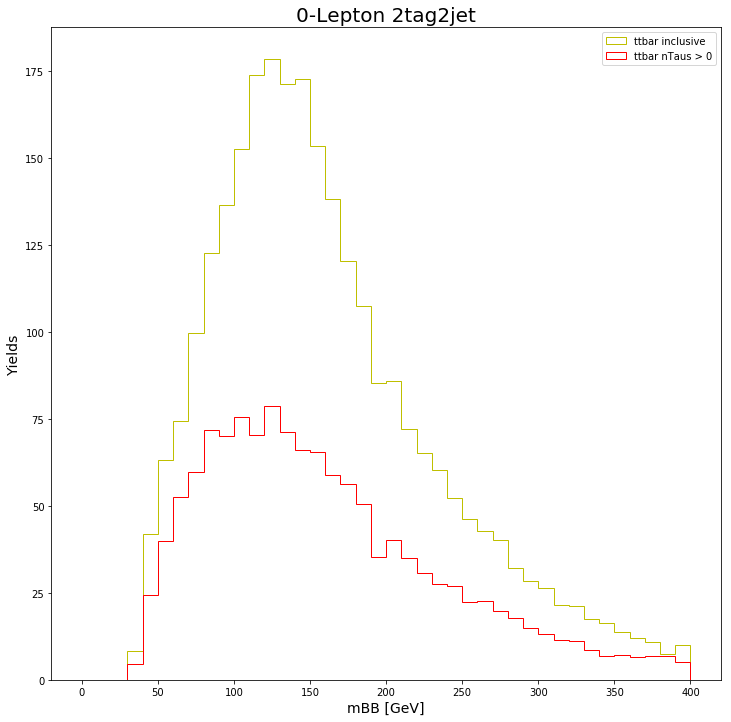

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
nJ = 2

DataFramenJ = DataFrame[DataFrame["nJ"] == nJ]
DataFrameSample = DataFramenJ[DataFramenJ["sample"] == b'ttbar']
DataFrameSample["mBB"].plot.hist(ax=ax, 
                                       histtype=u'step', 
                                       color = 'y',
                                       label = 'ttbar inclusive',
                                       legend=True, 
                                       bins= 40, 
                                       range=(0, 400),
                                       weights = DataFrameSample['EventWeight'],
                                       #density = True
                                        )

DataFrameSample = DataFramenJ[DataFramenJ["nTaus"] > 0]
DataFrameSample["mBB"].plot.hist(ax=ax, 
                                       histtype=u'step', 
                                       color = 'r',
                                       label = 'ttbar nTaus > 0',
                                       legend=True, 
                                       bins= 40, 
                                       range=(0, 400),
                                       weights = DataFrameSample['EventWeight'],
                                       #density = True
                                        )

ax.set_xlabel('mBB [GeV]', fontsize = 14)
ax.set_ylabel('Yields', fontsize = 14)
plt.title('0-Lepton 2tag' + str(nJ) + 'jet', fontsize = 20)
plt.legend(loc='upper right')
plt.show()

In [22]:
def plot2DheatMaps(samples, nJ, varX, xbins, xmin, xmax, varY, ybins, ymin, ymax, DataFrame, unitX = '', unitY = ''):
    """Plot heat maps"""
    
    
    DataFramenJ = DataFrame[DataFrame["nJ"] == nJ]
    
    
    fig, axes = plt.subplots(len(samples), 1, figsize=(12, 7*len(samples)))
    axes = axes.ravel()
    
    i=0
    for sample in samples:
        
        plt.sca(axes[i])
        
        samplename = str(sample)
        samplename = samplename.replace("b'",'',1)
        samplename = samplename.replace("'",'')
        
        DataFrameSample = DataFramenJ[DataFramenJ["sample"] == sample]
        
        TotEventWeight = DataFrameSample['EventWeight'].sum()
        plt.hist2d(DataFrameSample[varX], DataFrameSample[varY],
                                     bins=(xbins, ybins), range=((xmin,xmax),(ymin,ymax))
                  ) 
        
        

    
    
        if len(unitX) > 0:
            axes[i].set_xlabel(varX + ' [' + unitX + ']', x=0.9, y=0.6, fontsize = 14)
        else:
            axes[i].set_xlabel(varX, x=0.9, y=0.6, fontsize = 14)
    
        if len(unitY) > 0:
            axes[i].set_ylabel(varY + ' [' + unitY + ']', x=0.1, y=0.9, fontsize = 14)
        else:
            axes[i].set_ylabel(varY, x=0.1, y=0.9, fontsize = 14)

        plt.title('0-Lepton ' + samplename + ' 2tag' + str(nJ) + 'jet', fontsize = 20)
        plt.colorbar()
        plt.savefig('twoDim_' + samplename + '_' +  varX + '_' + varY + '_' + str(nJ) + 'njet' + '.pdf')
        
        i+=1

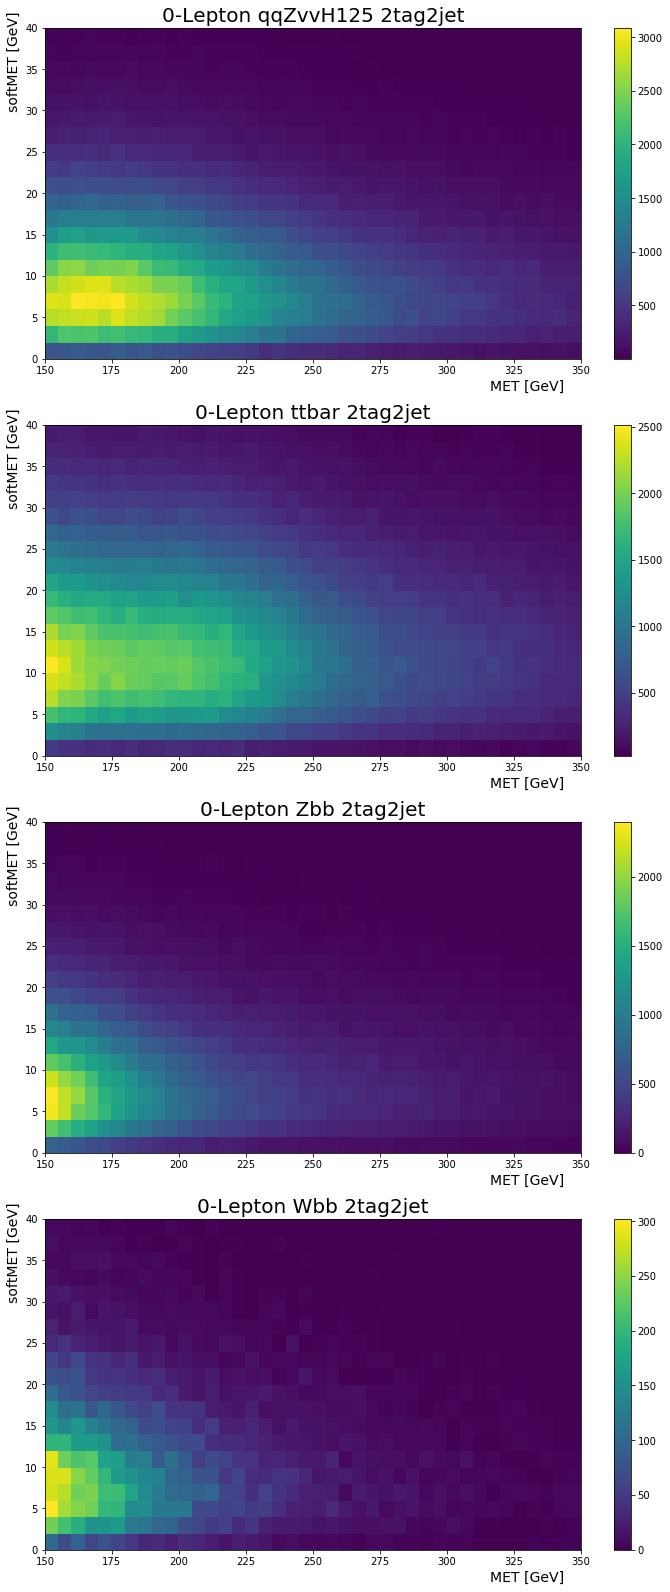

In [46]:
plot2DheatMaps([b'qqZvvH125',b'ttbar', b'Zbb', b'Wbb'], 2, "MET", 40, 150, 350, "softMET", 20, 0, 40, DataFrame, unitX = 'GeV', unitY = 'GeV')

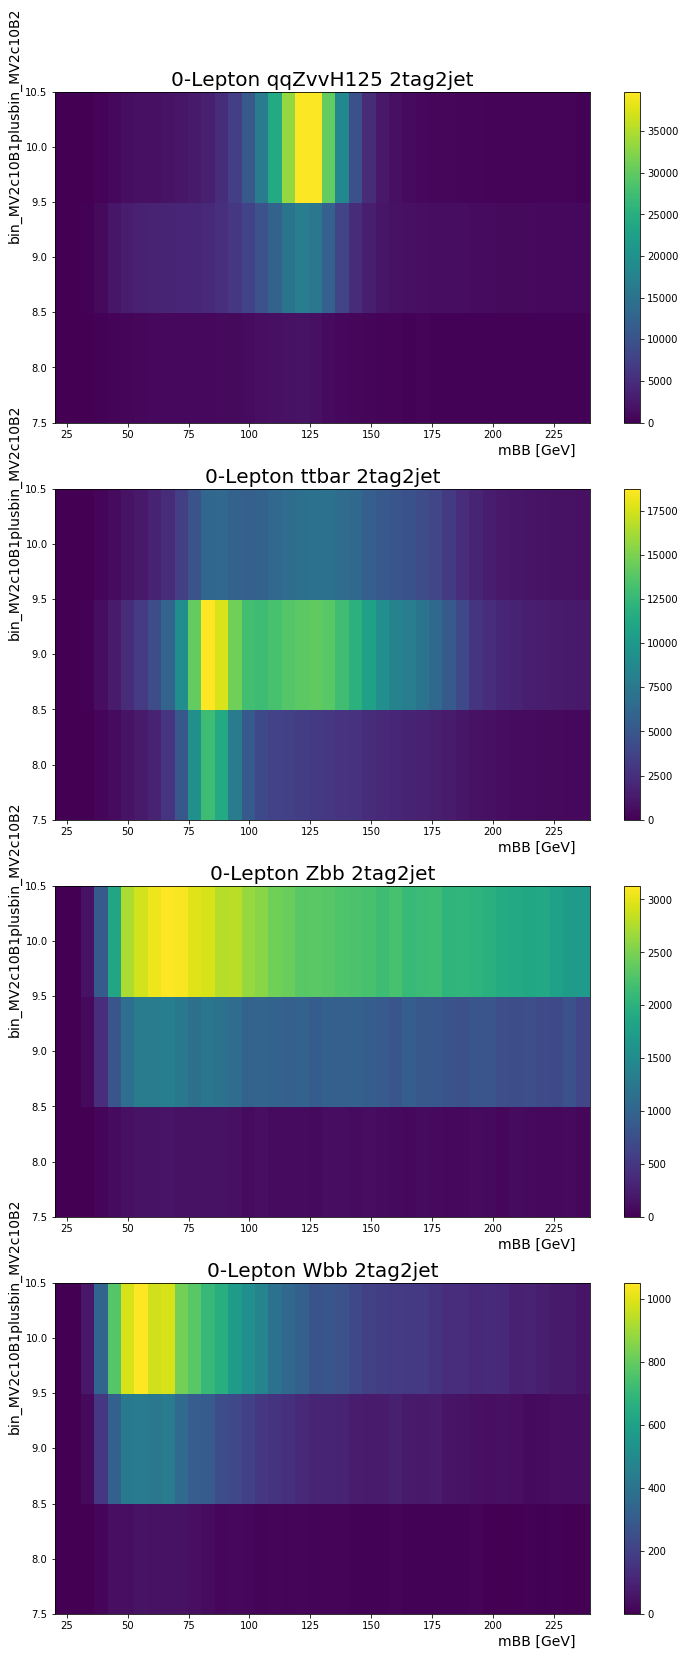

In [35]:
plot2DheatMaps([b'qqZvvH125',b'ttbar', b'Zbb', b'Wbb'], 2, "mBB", 40, 20, 240, "bin_MV2c10B1plusbin_MV2c10B2", 3, 7.5, 10.5, DataFrame, unitX = 'GeV')